In [50]:
from Toolv1 import MotionGenerator, GenerateTraj,random_rot,traj_to_dist
from Toolv1 import diffusive,subdiffusive,directed,accelerated,slowed
import numpy as np
ndim = 2

def add_miss_tracking(traj,N,f=10):
    
    step = traj[1:]-traj[:-1]
    
    std = np.average(np.sum(step**2,axis=1)**0.5)
    
    for i in range(N):
        w = np.random.randint(0,len(traj))
        traj[w] = np.random.normal(traj[w],f*std)
    
    return traj


def generate_N_nstep(N,nstep):
    add = 0
    ndim = 2
    if ndim == 3:
        add = 1
    size = nstep
    
    X_train = np.zeros((N,size,5))
    Y_trains_b = np.zeros((N,size,1))
    Y_trains_s = np.zeros((N,size,1))

    Y_train_traj = []

    #12
    for i in range(N):
    #for i in range(1000):

        #if i % 1000 == 0:
        #    print i
        sigma = max(np.random.normal(0.5,1),0.05)
        step = max(np.random.normal(1,1),0.2)
        tryagain = True
        while tryagain:
            try:


                clean=False
                
                time=size
                ndim=2
                list_generator = [MotionGenerator(time,ndim,
                                                  parameters=np.random.rand(3),
                                                  generate_motion=diffusive),
                                   MotionGenerator(time,ndim,
                                                  parameters=np.random.rand(3),
                                                  generate_motion=directed),
                                   MotionGenerator(time,ndim,
                                                  parameters=np.random.rand(3),
                                                  generate_motion=subdiffusive),
                
                                  MotionGenerator(time,ndim,
                                                  parameters=np.random.rand(3),
                                                  generate_motion=accelerated),
                                  MotionGenerator(time,ndim,
                                                  parameters=np.random.rand(3),
                                                  generate_motion=slowed),
                                   ]

                A = GenerateTraj(time,list_max_possible=[3,3,3,3,3],list_generator=list_generator)
                
                m0 = np.array(A.sequence) == "0_0"
                m1 = np.array(A.sequence) == "0_1"
                m2 = np.array(A.sequence) == "0_2"
 
                def map_sequence(sequence):
                    ns = []
                    for iseque in  sequence:
                        i0,j0 = map(int,iseque.split("_"))
                        ns.append(i0)
                    return ns
                
                real_traj = A.traj
                sc = map_sequence(A.sequence)

                alpharot = 2*3.14*np.random.random()
                

                
                real_traj  = random_rot(real_traj,alpharot,ndim=ndim)
                

                #print A.sequence
                #print real_traj.shape
                alligned_traj,normed,alpha,_ = traj_to_dist(real_traj,ndim=ndim)
                
                nzeros = np.random.randint(0,10)
                Z = []
                for _ in range(nzeros):
                    Z.append(np.random.randint(len(sc)-1))
                    sc[Z[-1]] = 5
           
                Z= list(set(Z)) 
                
                for zero in Z:
                    normed[zero,::] = 0
                    
                    
                #print  alligned_traj.shape ,len(sc)
            
                tryagain=False
                
                
            except IndexError:
                tryagain=True
                
        Y_train_traj.append(real_traj)
        #print X_train.shape
        X_train[i] = normed
        
      
        Y_trains_b[i][np.array(sc,dtype=np.int) == 0 ] = 1
        #print m0,sc

        Y_trains_s[i][m0] = np.mean(normed[m0,1])
        Y_trains_s[i][m1] = np.mean(normed[m1,1])
        Y_trains_s[i][m2] = np.mean(normed[m2,1])


        if Z != []:
            Y_trains_s[i][np.array(Z)] = 0
        #print sc

    
    return X_train,Y_trains_b,Y_trains_s,Y_train_traj

R = generate_N_nstep(1,10)
print R[1]
print R[2]


[[[ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]]]
[[[ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]]]


In [51]:
# this returns a tensor
from keras.layers import Input, Embedding, LSTM, Dense, merge,TimeDistributed
from Bilayer import BiLSTMv1 as BiLSTM
from keras.models import Model


inputs = Input(shape=(None,5),name="Input")

l1 = BiLSTM(output_dim=20,activation='tanh',return_sequences=True)(inputs)
l2 = BiLSTM(output_dim=20,activation='tanh',return_sequences=True)(merge([inputs,l1],mode="concat"))
l3 = BiLSTM(output_dim=20,activation='tanh',return_sequences=True)(merge([inputs,l2],mode="concat"))

brownian = BiLSTM(output_dim=20,activation='tanh',return_sequences=True,name="brownian_i")(merge([inputs,l1,l2,l3],mode="concat"))
brownian = TimeDistributed(Dense(1,activation="sigmoid"),name="brownian")(brownian)
sigma = BiLSTM(output_dim=20,activation='tanh',return_sequences=True,close=True,name="sigma_i")(merge([inputs,l1,l2,l3,brownian],mode="concat"))
sigma = TimeDistributed(Dense(1,activation="relu"),name="sigma")(sigma)

model = Model(input=[inputs],output=[brownian,sigma])#,sigma])

model.compile(optimizer='adadelta',
              loss={'sigma': 'mean_squared_error', 'brownian': 'binary_crossentropy'},
              loss_weights={'sigma': .1, 'brownian': .9})
"""
model.compile(optimizer='adadelta',
              loss={ 'brownian': 'binary_crossentropy'})"""

"\nmodel.compile(optimizer='adadelta',\n              loss={ 'brownian': 'binary_crossentropy'})"

In [181]:
model.load_weights("/home/jarbona/cluster_theano/ftest_7_50")

0
[[[ 0.50901252]
  [ 0.50268888]
  [ 0.49906114]
  [ 0.49648401]
  [ 0.49425328]
  [ 0.4921411 ]
  [ 0.49010983]
  [ 0.48817432]
  [ 0.48634967]
  [ 0.48463738]]

 [[ 0.50901252]
  [ 0.50268888]
  [ 0.49906114]
  [ 0.49648401]
  [ 0.49425328]
  [ 0.4921411 ]
  [ 0.49010983]
  [ 0.48817432]
  [ 0.48634967]
  [ 0.48463738]]

 [[ 0.50901252]
  [ 0.50268888]
  [ 0.49906114]
  [ 0.49648401]
  [ 0.49425328]
  [ 0.4921411 ]
  [ 0.49010983]
  [ 0.48817432]
  [ 0.48634967]
  [ 0.48463738]]

 [[ 0.50901252]
  [ 0.50268888]
  [ 0.49906114]
  [ 0.49648401]
  [ 0.49425328]
  [ 0.4921411 ]
  [ 0.49010983]
  [ 0.48817432]
  [ 0.48634967]
  [ 0.48463738]]

 [[ 0.50901252]
  [ 0.50268888]
  [ 0.49906114]
  [ 0.49648401]
  [ 0.49425328]
  [ 0.4921411 ]
  [ 0.49010983]
  [ 0.48817432]
  [ 0.48634967]
  [ 0.48463738]]

 [[ 0.50901252]
  [ 0.50268888]
  [ 0.49906114]
  [ 0.49648401]
  [ 0.49425328]
  [ 0.4921411 ]
  [ 0.49010983]
  [ 0.48817432]
  [ 0.48634967]
  [ 0.48463738]]

 [[ 0.50901252]
  [ 0.5026

In [47]:
import keras
import cPickle
class LossHistory(keras.callbacks.Callback):
    #losses = []
    #val_losses = []
    def __init__(self,name):
        super(LossHistory, self).__init__()
        self.name=name
        self.losses = []
        self.val_losses = []
    def on_train_begin(self, logs={}):
        
        pass
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        #self.val_losses.append(logs.get('val_loss'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        cPickle.dump((self.losses,self.val_losses), open(self.name, 'wb')) 
        


In [76]:
#from Specialist_layer import  return_three_layer,return_three_bis
history = LossHistory("losses16.pick")
#TRaining of graph 1
#print lr
#lr = 0.1
lr = 1.0
wgraph = model
wgraph.optimizer.lr.set_value(lr)
for i in range(15):
    for j in range(0,6*6*4,1):
    
        modulo = 5
        size = (1 + j % modulo)*50
       
        if j % modulo == 4:
            size=200
        if j % modulo == 5:
            size=400    
        if j % modulo == 3:
            size=26
        #size=26
        print size
        
        try:
        
            X_train,Y_trains_b,Y_trains_s,scs = generate_N_nstep(4000,size)

            inp = {"Input":X_train}
            ret={"brownian":Y_trains_b,
                "sigma":Y_trains_s}
            """#
            ret = {"input1":X_train,
                   "output":Y_trains,
                   "outputtype":convert_output(Y_trains),
                  "category":Y_train_cat[::,::,:12]}"""
            
        except:
            print "pb"
            pass
        #next(generator())
        
        #print ret["category"].shape
        if size == 400:
            wgraph.optimizer.lr.set_value(lr)
            print wgraph.optimizer.lr.get_value()
            
        if size == 50:
            wgraph.optimizer.lr.set_value(lr)
            print wgraph.optimizer.lr.get_value()
            
        if size != 600:
            batch = 50
        else:
            batch = 20
        #print ret.keys()
        #print ret["category"].shape, ret["output"].shape, 
        wgraph.fit(inp,ret,batch, nb_epoch=1,validation_split=0.05)#, callbacks=[history])
        
        if i == 3:
            lr = 0.1
        if j % modulo == 0 :
            name = "ftest_sigma"
            wgraph.save_weights(name + "_%i_%i"%(i+2,j),overwrite=True)
            #sub_with_noise (30p)
        
            
            #if np.isnan(graph.evaluate(ret)):
            #    graph = return_three_layer()
            #    graph.load_weights("transition_l8_%i_diff_size_50"%(i+2))
    #if i % 3 == 0 and i != 0:
    #    lr /= 2.
    #    graph.optimizer.lr.set_value(lr)
    #    print graph.optimizer.lr.get_value()

#score = model.evaluate(X_test, Y_test, batch_size=16)

50
1.0
Train on 3800 samples, validate on 200 samples
Epoch 1/1
3800/3800 [==============================] - 42s - loss: 0.3782 - brownian_loss: 0.3824 - sigma_loss: 0.3404 - val_loss: 0.3952 - val_brownian_loss: 0.3996 - val_sigma_loss: 0.3555
100
Train on 3800 samples, validate on 200 samples
Epoch 1/1
3800/3800 [==============================] - 73s - loss: 0.3771 - brownian_loss: 0.3798 - sigma_loss: 0.3529 - val_loss: 0.3821 - val_brownian_loss: 0.3856 - val_sigma_loss: 0.3508
150
Train on 3800 samples, validate on 200 samples
Epoch 1/1
3800/3800 [==============================] - 118s - loss: 0.3849 - brownian_loss: 0.3869 - sigma_loss: 0.3673 - val_loss: 0.3575 - val_brownian_loss: 0.3581 - val_sigma_loss: 0.3521
26
Train on 3800 samples, validate on 200 samples
Epoch 1/1
3800/3800 [==============================] - 22s - loss: 0.3488 - brownian_loss: 0.3537 - sigma_loss: 0.3048 - val_loss: 0.3277 - val_brownian_loss: 0.3339 - val_sigma_loss: 0.2714
200
Train on 3800 samples, va

KeyboardInterrupt: 

In [104]:
X_train,Y_trains_b,Y_trains_s,scs = generate_N_nstep(200,200)

inp = {"Input":X_train}
ret={"brownian":Y_trains_b,
    "sigma":Y_trains_s}

In [85]:
resp  = model.predict(inp["Input"][:20])


(200,)
(200,)


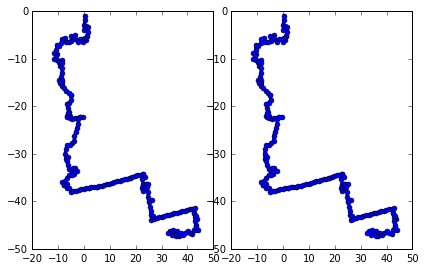

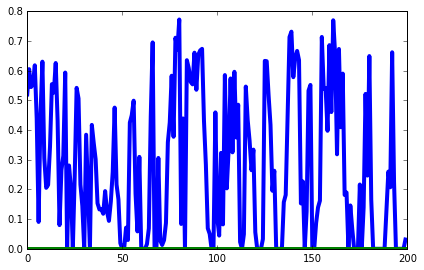

In [105]:
from Tools import plot_by_class,plot_label
import copy
w = 16
res = copy.deepcopy(resp[0][w])[::,0]
res[res >0.5] = 1
res[res<0.5] = 0
gt = Y_trains_b[w][::,0]
print res.shape
print gt.shape
#print resp[1][w][::,0]
fig = figure()
ax = fig.add_subplot(121)
plot_label(np.cumsum(inp["Input"][w][::,2:4],axis=0),res,remove6=9)
ax = fig.add_subplot(122)

plot_label(np.cumsum(inp["Input"][w][::,2:4],axis=0),gt,remove6=9)

figure()
plot(resp[1][w][::,0])
plot(ret["sigma"][w][::,0])


In [138]:
print ret["brownian"][w][:10]

[[ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
